In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, LSTM, Activation, Reshape, Concatenate, BatchNormalization, LayerNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.models import Model
import os

In [2]:
context_window=(26,26)
batch_size=32

In [3]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\IDS_IPS Softmax Classification\Datasets\Final Datasets\Train\Images",
    color_mode='rgb',
    image_size=context_window,
    batch_size=128,
    shuffle=True,
)

Found 18001 files belonging to 9 classes.


In [21]:
test_dataset=tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\IDS_IPS Softmax Classification\Datasets\Final Datasets\Test\Images",
    color_mode='rgb',
    image_size=context_window,
    batch_size=128,
    shuffle=False,
)

Found 4493 files belonging to 9 classes.


In [5]:
def CNN_model():
    initializers=tf.keras.initializers.RandomNormal(seed=1)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(26,26,3)),
        tf.keras.layers.Conv2D(16,kernel_size=(1,3),strides=(1,1),padding="same",kernel_initializer=initializers),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Conv2D(16,kernel_size=(1,3),strides=(1,1),padding="same",kernel_initializer=initializers),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Conv2D(16,kernel_size=(1,3),strides=(1,1),padding="same",kernel_initializer=initializers),
    ])

    return model

In [6]:
def LSTM_model(input_shape=(26,26,3),n_a=512,n_h=8,n_values=9, context_window=26):

    # Kernel Initializer
    initializers = tf.keras.initializers.RandomNormal(seed=1)
    # Reshapers
    reshaper_input = Reshape((1,input_shape[1]*input_shape[2]))
    reshaper_temporal = Reshape((1,n_a//4))
    reshaper_output = Reshape((input_shape[0]*n_a//4,))
    # LSTM and Dense Cells
    LSTMcell = LSTM(n_a, return_state=True, kernel_initializer=initializers)
    Densor1 = Dense(n_a/2, kernel_initializer=initializers, activation="relu")
    Densor2 = Dense(n_a/4,kernel_initializer=initializers,activation="relu")
    # Self Attention Mechanism
    key = Dense(n_a/4,kernel_initializer=initializers,activation="relu")
    query = Dense(n_a/4,kernel_initializer=initializers,activation="relu")
    value = Dense(n_a/4,kernel_initializer=initializers,activation="relu")
    # Concatenate temporal outputs 
    concat = Concatenate(axis=1)
    # Softmax to obtain prediction
    Densor_softmax = Dense(n_values, kernel_initializer=initializers, activation='linear')

    # Model Architecture
    inputs = Input(shape=input_shape)
    outputs = []

    # LSTM and Dense Cells
    for i in range(context_window):
        x = inputs[:, i, :, :]
        x = reshaper_input(x)
        if i==0:
            _, a, c = LSTMcell(x)
        else:
            _, a, c = LSTMcell(x,initial_state=[a,c])
        out = Densor1(a)
        out = Densor2(out)
        out = reshaper_temporal(out)
        outputs.append(out)
    
    # Concatenate temporal dimension
    outputs = concat(outputs)
    # Embedding Dimension for each head
    n_dk = (n_a//4)//n_h
    sqrt_dk = tf.math.sqrt(tf.cast(n_dk,tf.float32))
    # Multi Head Self Attention
    q = query(outputs)
    q = Reshape((input_shape[0],n_h,n_dk))(q)
    q = tf.transpose(q,perm=[0,2,1,3])
    k = key(outputs)
    k = Reshape((input_shape[0],n_h,n_dk))(k)
    k = tf.transpose(k,perm=[0,2,3,1])
    v = value(outputs)
    v = Reshape((input_shape[0],n_h,n_dk))(v)
    v = tf.transpose(v,perm=[0,2,1,3])
    self_attention_scores = tf.nn.softmax(tf.matmul(q,k)/sqrt_dk,axis=-1)
    self_attention = tf.matmul(self_attention_scores,v)
    self_attention = tf.transpose(self_attention,perm=[0,2,1,3])
    self_attention = Reshape((input_shape[0],n_a//4))(self_attention)
    # Output reshape
    outputs = reshaper_output(self_attention)
    # Feed Forward Network
    outputs = Dense(n_a//4,kernel_initializer=initializers,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01))(outputs)
    # Softmax output
    outputs = Densor_softmax(outputs)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [7]:
def CNN_LSTM_model():
    input = Input(shape=(26,26,3))
    x = CNN_model()(input)
    output = LSTM_model((26,26,16),512,8,9,26)(x)
    
    model = Model(inputs=[input],outputs=[output])

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )

    return model

In [8]:
model = CNN_LSTM_model()

In [9]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 26, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 26, 26, 16)        1728      
                                                                 
 model (Functional)          (None, 9)                 2543625   
                                                                 
Total params: 2,545,353
Trainable params: 2,545,353
Non-trainable params: 0
_________________________________________________________________


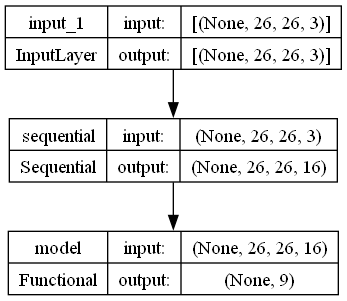

In [10]:
tf.keras.utils.plot_model(model,to_file="Softmax_LSTM_CNN_attention_model.png",show_shapes=True)

In [10]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.prev_loss=0
    def on_epoch_end(self,epoch,logs={}):
        model.save(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/CNN_LSTM_attention models/model_{epoch}.h5")
        if(epoch>0 and logs.get('loss')>=self.prev_loss):
            print('\nLearning rate updated')
            self.model.optimizer.lr.assign(self.model.optimizer.lr.read_value()*0.1)
        self.prev_loss=logs.get('loss')

callbacks=myCallback()

In [11]:
history=model.fit(train_dataset,validation_data=test_dataset,batch_size=128,epochs=30,callbacks=[callbacks])

Epoch 1/30


141/141 [==============================] - 96s 281ms/step - loss: 9.2925 - accuracy: 0.8988 - val_loss: 7.2812 - val_accuracy: 0.9933
Epoch 2/30
141/141 [==============================] - 26s 179ms/step - loss: 6.0016 - accuracy: 0.9982 - val_loss: 4.8769 - val_accuracy: 0.9944
Epoch 3/30
141/141 [==============================] - 25s 177ms/step - loss: 4.0109 - accuracy: 0.9992 - val_loss: 3.2554 - val_accuracy: 0.9967
Epoch 4/30
141/141 [==============================] - 25s 179ms/step - loss: 2.6716 - accuracy: 0.9992 - val_loss: 2.1725 - val_accuracy: 0.9944
Epoch 5/30
141/141 [==============================] - 26s 180ms/step - loss: 1.7718 - accuracy: 0.9995 - val_loss: 1.4403 - val_accuracy: 0.9942
Epoch 6/30
141/141 [==============================] - 25s 175ms/step - loss: 1.1699 - accuracy: 0.9994 - val_loss: 0.9597 - val_accuracy: 0.9942
Epoch 7/30
141/141 [==============================] - 25s 177ms/step - loss: 0.7687 - accuracy: 0.9993 - val_loss: 0.6314 - val_accuracy: 0.9

In [12]:
# Emergency Save
model.save(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/CNN_LSTM_attention models/model_{30}.h5")

In [13]:
import json

with open(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/CNN_LSTM_attention.txt","w") as file:
    file.write(json.dumps(history.params))
with open(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/CNN_LSTM_attention_history.txt","w") as file:
    file.write(json.dumps(history.history))

In [14]:
model=tf.keras.models.load_model(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/CNN_LSTM_attention models/model_{29}.h5")

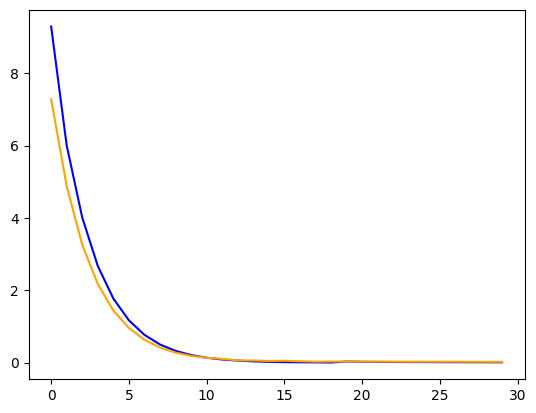

In [15]:
plt.plot(range(30),history.history["loss"],color="blue",label="Train Loss")
plt.plot(range(30),history.history["val_loss"],color="orange",label="Validation Loss")
plt.show()

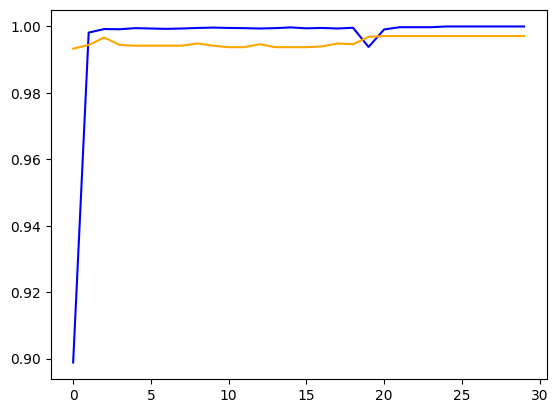

In [16]:
plt.plot(range(30),history.history["accuracy"],color="blue",label="Train Accuracy")
plt.plot(range(30),history.history["val_accuracy"],color="orange",label="Validation Accuracy")
plt.show()

In [22]:
model.evaluate(train_dataset)
model.evaluate(test_dataset)

36/36 [==============================] - 3s 86ms/step - loss: 0.0227 - accuracy: 0.9971


[0.022676756605505943, 0.9971066117286682]

In [23]:
Y_test=np.concatenate([y for x,y in test_dataset],axis=0)

In [24]:
y_predict=np.argmax(tf.nn.softmax(model.predict(test_dataset)),axis=1)

36/36 [==============================] - 3s 73ms/step


In [25]:
confusion_matrix=tf.math.confusion_matrix(Y_test,y_predict)
confusion_matrix

<tf.Tensor: shape=(9, 9), dtype=int32, numpy=
array([[3073,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  384,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,  384,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,   59,    0,    1,    0,    0,    0],
       [   0,    0,    0,    0,   45,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,   32,   12,    0,    0],
       [   0,    0,    0,    0,    0,    0,   41,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,  384,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,   78]])>

In [26]:
from mlxtend.plotting import plot_confusion_matrix

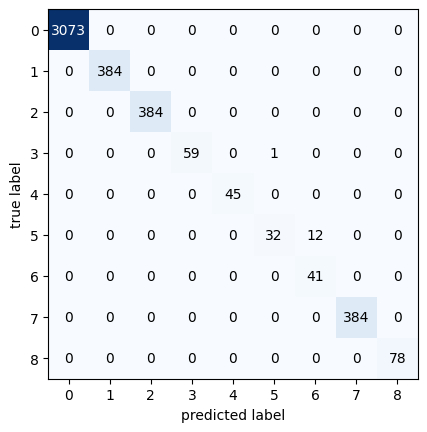

In [27]:
fig,ax=plot_confusion_matrix(confusion_matrix.numpy())
plt.show()